# 6. BBox Regression Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from dataset import *
from vnet import *
from training import *
from niiutility import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 6.1 Setup Torch Global Variable, load memory map 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 8
NUM_WORKERS = 8
NUM_TRAIN = 279
LEARNING_RATE = 1e-2

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

using GPU for training


* BvMaskDataset, return image and bbox tuple of 6

In [4]:
#-------------------------LOAD THE DATA SET-------------------------------------------#
regen = False

if regen:
    data_index = np.arange(370)
    data_idnex = np.stack ([np.random.shuffle(data_index[:259]),np.random.shuffle(data_index[259:])])
    print(list(data_index))
else:
    data_index = np.array ([120, 148, 24, 124, 200, 76, 159, 186, 125, 164, 251, 155, 0, 252, 238, 103, 53, 179, 244, 149, 45, 31, 131, 115, 82, 216, 130, 213, 245, 199, 229, 254, 56, 158, 32, 86, 221, 84, 81, 196, 117, 38, 28, 218, 257, 7, 237, 181, 105, 194, 16, 104, 75, 78, 249, 87, 144, 1, 183, 203, 54, 255, 129, 253, 202, 25, 34, 132, 80, 89, 137, 201, 114, 189, 110, 4, 71, 195, 97, 33, 157, 21, 250,
                            192, 258, 49, 47, 119, 191, 217, 143, 68, 190, 11, 176, 206, 108, 226, 50, 69, 118, 61, 35, 57, 243, 154, 15, 102, 146, 174, 163, 156, 233, 37, 180, 100, 184, 55, 239, 135, 151, 101, 205, 220, 169, 134, 228, 234, 51, 145, 29, 207, 141, 142, 44, 175, 12, 198, 52, 8, 30, 17, 10, 2, 126, 256, 40, 85, 46, 139, 178, 235, 23, 70, 188, 209, 93, 5, 153, 172, 127, 64, 241, 182, 18, 236, 187, 79, 210, 96,
                            3, 99, 63, 123, 171, 48, 6, 165, 43, 9, 230, 211, 19, 242, 162, 161, 173, 73, 106, 59, 136, 90, 112, 167, 246, 227, 109, 225, 41, 160, 133, 22, 177, 168, 14, 152, 107, 122, 223, 74, 62, 185, 222, 13, 150, 42, 212, 248, 147, 128, 67, 83, 214, 94, 98, 219, 232, 58, 247, 88, 66, 140, 116, 92, 113, 215, 27, 60, 138, 231, 39, 72, 166, 170, 91, 77, 224, 208, 240, 95, 26, 204, 197, 121, 36, 111, 193,
                            65, 20, 324, 330, 325, 262, 351, 366, 269, 365, 369, 297, 316, 363, 293, 267, 302, 313, 352, 307, 335, 290, 356, 286, 328, 320, 340, 333, 322, 355, 315, 296, 299, 312, 341, 261, 306, 282, 283, 292, 298, 321, 346, 310, 361, 265, 314, 331, 358, 305, 349, 276, 285, 368, 271, 317, 367, 336, 279, 275, 323, 277, 281, 337, 309, 260, 357, 266, 278, 294, 319, 332, 273, 303, 280, 284, 304, 334, 360, 300, 353, 308, 345, 364, 311, 270, 362, 339, 289, 342, 348, 263, 287, 274, 295, 327, 268, 272, 318, 354, 259, 329, 350, 359, 344, 338, 343, 288, 291, 347, 264, 326, 301])
    
dataset_trans = DatasetBV(data_index,
                         transform=transforms.Compose([
                             RandomAffine(180, 15, 1, DS=2),
                             RandomFilp(0.5),
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

0 torch.Size([8, 1, 128, 128, 128]) torch.Size([8, 6])


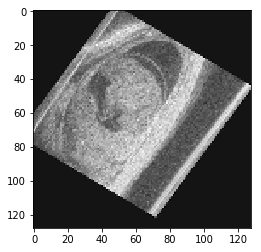

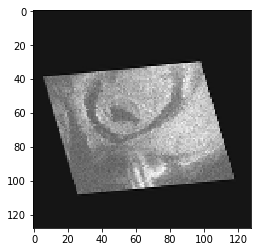

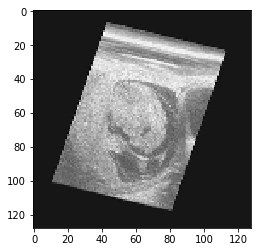

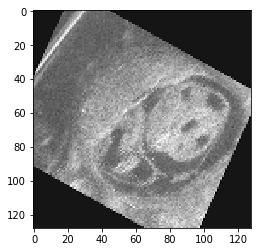

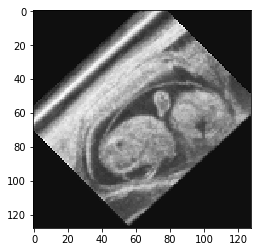

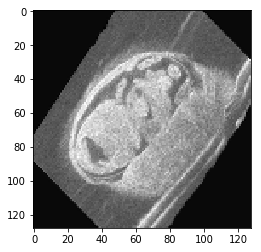

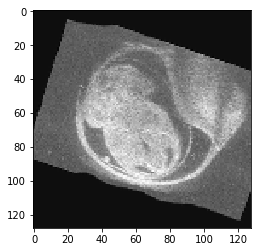

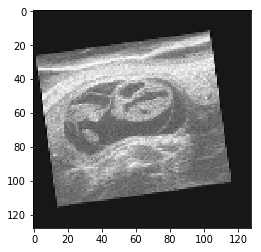

tensor([[ 72, 106,  45,  77,  38,  63],
        [ 52,  94,  43,  70,  41,  71],
        [ 34,  63,  45,  83,  56,  83],
        [ 50,  78,  40,  85,  80, 111],
        [ 54,  93,  62,  98,  36,  69],
        [ 33,  76,  57,  93,  27,  54],
        [ 47,  91,  62,  96,  51,  82],
        [ 37,  71,  42,  64,  51,  85]])
1 torch.Size([8, 1, 128, 128, 128]) torch.Size([8, 6])


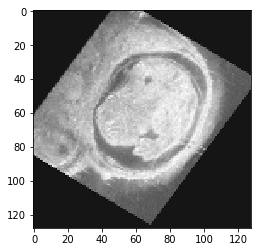

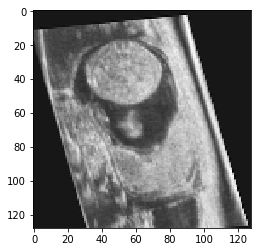

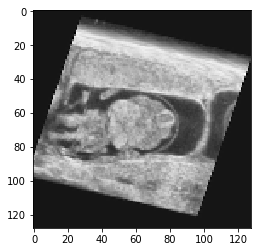

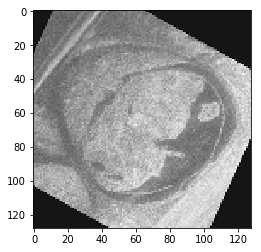

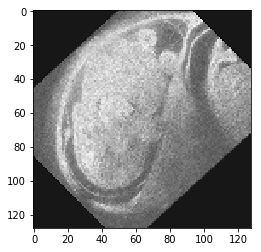

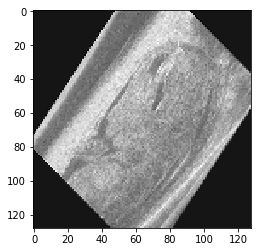

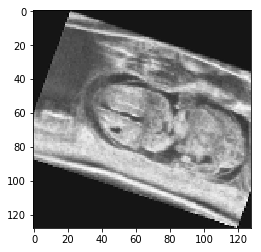

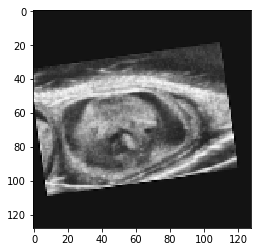

tensor([[ 24,  55,  35,  75,  30,  80],
        [ 78, 115,  45,  87,  34,  64],
        [ 59, 101,  58,  84,   4,  38],
        [ 61, 100,  85, 108,  32,  76],
        [ 77, 118,  65, 106,  37,  69],
        [ 52,  88,  23,  67,  64, 107],
        [ 48,  86,  46,  73,  38,  65],
        [ 36,  62,  54,  92,  18,  50]])
2 torch.Size([8, 1, 128, 128, 128]) torch.Size([8, 6])


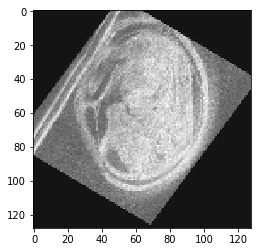

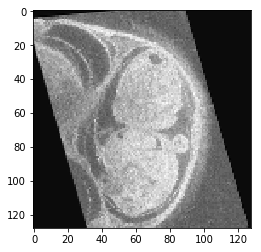

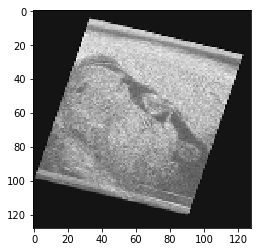

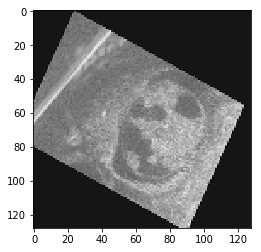

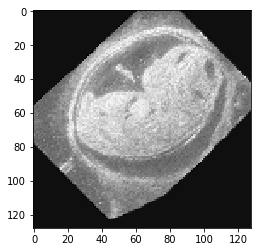

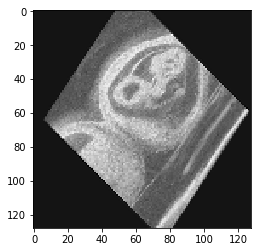

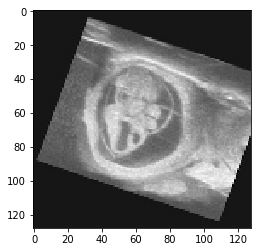

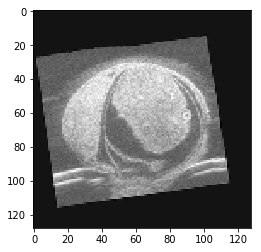

tensor([[ 60,  85,  73, 100,  41,  88],
        [ 38,  88,  25,  53,  55,  81],
        [ 55, 108,  36,  64,  20,  56],
        [ 57,  77,  41,  66,  56,  97],
        [ 48,  90,  21,  55,  78, 107],
        [ 38,  67,  38,  65,  44,  76],
        [ 43,  75,  50,  84,  42,  64],
        [ 70,  97,  39,  79,  58,  90]])
3 torch.Size([8, 1, 128, 128, 128]) torch.Size([8, 6])


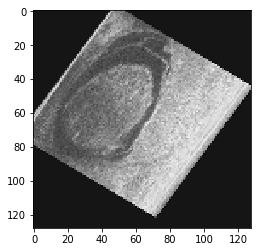

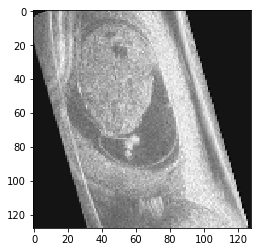

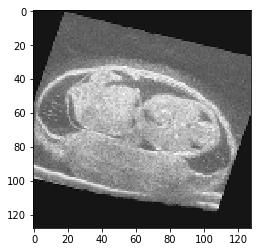

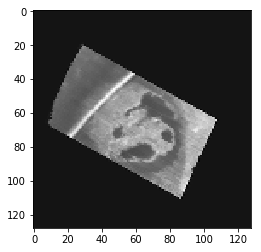

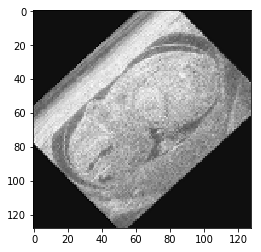

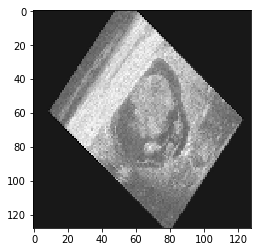

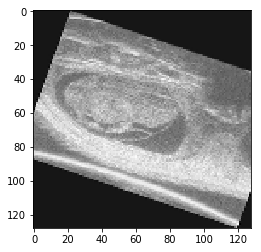

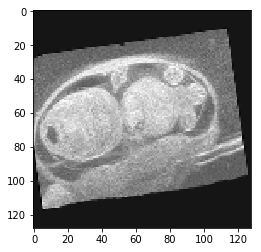

tensor([[ 37,  78,  22,  64,  78, 107],
        [ 50,  91,  11,  55,  29,  59],
        [ 51,  99,  58,  86,  83, 110],
        [ 51,  72,  63,  87,  45,  81],
        [ 44,  88,  66, 102,  25,  52],
        [ 27,  60,  41,  82,  55,  78],
        [ 16,  59,  56,  77,  51,  90],
        [ 41,  91,  58,  82,   7,  37]])


In [5]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    show_batch_image(sample_batched['image'],BATCH_SIZE,None)
    print(sample_batched['label'])

    # observe 4th batch and stop.
    if i_batch == 3:
        break

In [6]:
from vnet import LNet

LoadCKP = False

CKPPath = 'checkpoint2019-04-05 19:46:58.793496.pth'

model = LNet(img_size=(128, 128, 128), out_size=6)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, verbose=True)
logger = {'train':[], 'validation':[]}

if LoadCKP:
    loadckp(model, optimizer, scheduler, logger, CKPPath, device=device)

In [ ]:
#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

from loss import *

train(model, train_loader, validation_loader, optimizer, scheduler,\
      device=device, dtype=dtype, lossFun=MSE, logger=logger, epochs=5000, startepoch=0)

Epoch 0 finished ! Training Loss: 2267.4060
     validation loss = 565.3830
Checkpoint 1 saved !
Epoch 1 finished ! Training Loss: 459.8142
     validation loss = 426.3964
Epoch 2 finished ! Training Loss: 405.3682
     validation loss = 442.3253
Epoch 3 finished ! Training Loss: 370.9906
     validation loss = 439.6664
Epoch 4 finished ! Training Loss: 394.8182
     validation loss = 395.9830
Epoch 5 finished ! Training Loss: 383.7371
     validation loss = 420.9984
Epoch 6 finished ! Training Loss: 362.2436
     validation loss = 455.2053
Epoch 7 finished ! Training Loss: 377.1506
     validation loss = 384.8371
Epoch 8 finished ! Training Loss: 366.7000
     validation loss = 382.0685
Epoch 9 finished ! Training Loss: 368.5833
     validation loss = 444.3705
Epoch 10 finished ! Training Loss: 396.9094
     validation loss = 378.3111
Epoch 11 finished ! Training Loss: 388.5297
     validation loss = 385.6254
Epoch 12 finished ! Training Loss: 370.0950
     validation loss = 355.9879


In [ ]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'LNET-404.pth'
torch.save(model.state_dict(), PATH)